# Projection onto Convex set(POCS)で信号復元してみたかった

## @mitusimi_miyata (宮田光臣)


## POCSってなに？
- 読んで　https://en.wikipedia.org/wiki/Projections_onto_convex_sets　

## 今日何するの？
- 適当な空間でスパースな元信号データがあるとする。その信号にFTかけて周波数空間でランダムかつ疎にサンプリング→IFTかけると白色雑音ぽいものが乗った信号が得られる。これをソフトしきい値処理処理する、さらにFTかける、IFTかける、ソフトしきい値処理するの繰り返しで信号の復元
- スパースモデリングとか、圧縮センシングでぐぐって

### 応用先1
- Compressed Sensing(CS 圧縮センシング)MRI 
   - ↑確か2016~2017年以降発売のMRIは圧縮センシング機能が入っていて高速な撮像が可能
   
### 応用先2
- CS-血管造影CT

In [35]:
using FFTW
using Gadfly
using Random

In [14]:
data = zeros(128)
data[11] = 0.2
data[31] = 1.0
data[51] = 0.6
data[71] = 0.4
data[91] = 0.8
data[111] = 0.7

0.7

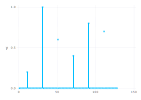

In [52]:
plot(y = data, Geom.bar, Geom.point)

In [55]:
function random_sampling(sp_data, n_data)
    #sp_data :　スパースな1Dデータ
    #n_data : length(sp_data)
    #1D FFTを行って実部と虚部に分ける、両方F64のArray
    FFT = fft(sp_data)
    datar = real(FFT)
    datai = imag(FFT)

    #コピーの作成
    xr = datar
    xi = datai

    #空データの作成
    datar = zeros(n_data)
    datai = zeros(n_data)

    #中央にデータを入れる
    #datar[Int64(n_data/2)+1] = xr[Int64(n_data/2)+1]
    #datai[Int64(n_data/2)+1] = xi[Int64(n_data/2)+1]
    datar[Int64(n_data/2)] = xr[Int64(n_data/2)]
    datai[Int64(n_data/2)] = xi[Int64(n_data/2)]

    for k in 2:Int64(n_data/2)
        fwhm = 0.6 #ガウス型半値幅
        ix =  Int64(round(n_data * fwhm * randn!(zeros(1))[1] / (2.0 * sqrt(2.0 * log(2.0))) + n_data / 2))
        #ix -= ix % 1
        #ix = Int64(ix)
        if (ix < 1 || ix > n_data)
            k -= 1

        elseif datar[ix] == 0.0
            datar[ix] = xr[ix]
            datai[ix] = xi[ix]
        else
            k -= 1
        end
    end
    return datar + datai * im
end

random_sampling (generic function with 1 method)

In [56]:
FFTdata = random_sampling(data, length(data))

128-element Array{Complex{Float64},1}:
                 0.0 + 0.0im                
 -0.3603334560003122 - 0.04732658769411574im
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
  0.6363961030678924 + 1.2020815280171306im 
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                     ⋮                      
                 0.0 + 0.0im                
 -1.2794114704756192 - 0.6055762771870294im 
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                 0.0 + 0.0im                
                

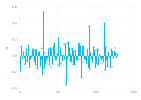

In [63]:
plot(y= real(ifft(FFTdata)/0.5), Geom.bar, Geom.point)

In [58]:
#sampled data real
spd = real(ifft(FFTdata)/0.5)
@show spd[11] #0.2
@show spd[31] #1.0
@show spd[51] #0.6
@show spd[71] #0.4
@show spd[91] #0.8
@show spd[111] #0.7

spd[11] = 0.12534154925849716
spd[31] = 0.539491074005384
spd[51] = 0.22159528977243342
spd[71] = 0.056756693555174466
spd[91] = 0.3625067018979473
spd[111] = 0.40286747560946895


0.40286747560946895

In [59]:
comp_fft_sig = random_sampling(data, length(data))

rand_sampling = ifft(comp_fft_sig)

@show rand_sampling[11] #0.2
@show rand_sampling[31] #1.0
@show rand_sampling[51] #0.6
@show rand_sampling[71] #0.4
@show rand_sampling[91] #0.8
@show rand_sampling[111] #0.7

iter = rand_sampling
xreal = real(iter)
ximag = imag(iter)
λ = 0.05

for i in 1:2000
    #iFFT
    if i == 1
        println("start")
    else
        iter = ifft(iter)
    end
    #soft threash
    for l in 1:length(data)
        #実部
        if abs(real(iter[l])) < λ
            xreal[l] = 0
        else
            xreal[l] = (abs(real(iter[l]))-λ) * real(iter[l]) / abs(real(iter[l]))
        end
        #虚部
        if abs(imag(iter[l])) < λ
            ximag[l] = 0
        else
            ximag[l] = (abs(imag(iter[l]))-λ) * imag(iter[l]) / abs(imag(iter[l]))
        end
    end
    iter = fft(xreal + ximag * im)
    for nx in 1:length(data)
        if real(comp_fft_sig[nx]) !=0
            iter[nx] = fft(ifft(comp_fft_sig))[nx]
        end
    end
end

iter_last = ifft(iter)
@show iter_last[11]
@show iter_last[31]
@show iter_last[51]
@show iter_last[71]
@show iter_last[91]
@show iter_last[111]

rand_sampling[11] = 0.02072276235210186 + 0.04518833923463394im
rand_sampling[31] = 0.28449107410092334 + 0.04575346002974338im
rand_sampling[51] = 0.16788516789213828 + 0.029924035669785083im
rand_sampling[71] = 0.08302351773559906 - 0.010278860601491623im
rand_sampling[91] = 0.23777026627938191 - 0.04237180565729136im
rand_sampling[111] = 0.17350031236009947 - 0.049623657874444976im
start
iter_last[11] = 0.06582950392317252 + 0.01432902425682411im
iter_last[31] = 0.8525349891675478 + 0.013301213471209536im
iter_last[51] = 0.4662618458991176 + 0.005218988234990861im
iter_last[71] = 0.2662618458991173 - 0.0052189882349909355im
iter_last[91] = 0.6525349891675478 - 0.013301213471209536im
iter_last[111] = 0.5658295039231725 - 0.014329024256824138im


0.5658295039231725 - 0.014329024256824138im

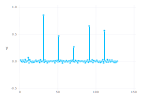

In [62]:
plot(y=real(iter_last), Geom.point, Geom.bar)

### 参考文献
- Lustig et.al. Sparse MRI: The application of compressed sensing for rapid MR imaging, , Magnetic Resonance in Medicine,Volume58, Issue6 December 2007 Pages 1182-1195
- yomichi, 実例で学ぶプログラミング言語Julia v1.0, 2018
- 篠原, 橋本, 圧縮センシングMRIの基礎, 医療科学社, 2016
- Elad著, 玉木訳, スパースモデリング: l1/ l0 ノルム最小化の基礎理論と画像処理への応用, 共立出版, 2016